In [1]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
import time
import copy
import torch.optim as optim

In [2]:
class ImageReader(Dataset):
    def __init__(self, raw_data_path, transform):
        data = np.genfromtxt(raw_data_path, delimiter=',', dtype=np.float32, skip_header=1)
        self.x = torch.from_numpy(data[:, 1:])
        self.y = torch.from_numpy(data[:, 0])
        self.n_samples = data.shape[0]
        self.transform = transform
    
    def __getitem__(self, idx):
        img = self.x[idx]
        labels = self.y[idx].type(torch.LongTensor)
        
        if self.transform is not None:
            img = self.transform(img)
    
        return img, labels
    
    def __len__(self):
        return self.n_samples

In [3]:
def reshape_tensor(tensor_x):
    return tensor_x.reshape([28,28])

def repeat_tensor(greyscale_tensor):
    return np.repeat(greyscale_tensor[np.newaxis,:,:], 3, axis=0)

transform = transforms.Compose([
        transforms.Lambda(lambda x: reshape_tensor(x)),
        #transforms.Lambda(lambda x: repeat_tensor(x)),
        transforms.ToPILImage(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transforms.Normalize([0.5], [0.5])
    ])

In [5]:
raw_data_path = "D:/Data/sign/sign_mnist_train/sign_mnist_train.csv"
dataset = ImageReader(raw_data_path, transform = transform)
dataset_size = dataset.__len__()

train_size = int(0.9 * dataset_size)
val_size = dataset_size - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])
#dataloader = DataLoader(dataset, batch_size = 4, shuffle =True)
trainloader = DataLoader(train_set, batch_size = 64, shuffle =True)
valloader = DataLoader(val_set, batch_size = 64, shuffle =True)

In [6]:
# get some random training images
dataiter = iter(trainloader)
data = dataiter.next()
images, labels = data
print(images.shape)
#print(labels)

torch.Size([64, 1, 28, 28])


In [7]:
small_letters = list(map(chr, range(ord('a'), ord('z')+1)))
small_letters = [letter for letter in small_letters if letter not in ['j', 'z']]
print(small_letters) # we don't have j or z

num_classes = len(small_letters)
print(num_classes)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']
24


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


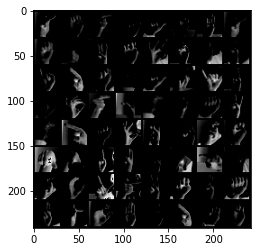

In [8]:
def imshow(img, title = None):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

grid = torchvision.utils.make_grid(images)
#imshow(grid, title = [small_letters[t] for t in labels])
imshow(grid, title = None)

In [9]:
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        self.softmax = nn.LogSoftmax(dim = 0)
        self.conv1 = nn.Conv2d(in_channels =1, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels =16, out_channels=64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 26)
        
    def forward(self, x):
        x = F.relu(self.conv1(x)) 
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        
        return x

model = Net().cuda()
#model = Net()
#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
model

Net(
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (softmax): LogSoftmax(dim=0)
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=26, bias=True)
)

In [11]:
total_epochs = 10
train_losses = []
val_losses = []

for epoch in range(total_epochs):  # loop over the dataset multiple times
    
    train_loss, valid_loss = 0.0, 0.0
    train_corr, valid_corr = 0, 0
    train_total, valid_total = 0, 0
    
    model.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # forward + backward + optimize
        outputs = model(inputs)
        optimizer.zero_grad()
        #loss = criterion(outputs, torch.max(labels, 1)[1])
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs.data, 1)
        
        #train_acc = (preds == labels).float().mean()
        train_total += labels.size(0)
        train_corr += (preds == labels).sum().item()
        
    model.eval()
    for i, data in enumerate(valloader, 0):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        #loss = criterion(outputs, torch.max(labels, 1)[1])
        loss = criterion(outputs, labels)
        valid_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs.data, 1)
        
        #val_acc = (preds == labels).float().mean()
        valid_total += labels.size(0)
        valid_corr += (preds == labels).sum().item()
            
    train_loss = train_loss/len(trainloader.sampler)
    val_loss = valid_loss/len(valloader.sampler)
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
        
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    print('Training Accuracy {:.2f} \tValidation Accuracy: {:.2f}'.format(train_corr/train_total, 
                                                                          valid_corr/valid_total))

print('Finished Training')

Epoch: 0 	Training Loss: 1.856255 	Validation Loss: 3944.278555
Training Accuracy 0.83 	Validation Accuracy: 0.95
Epoch: 1 	Training Loss: 1.355025 	Validation Loss: 3619.743735
Training Accuracy 0.97 	Validation Accuracy: 0.97
Epoch: 2 	Training Loss: 1.289739 	Validation Loss: 3500.265533
Training Accuracy 0.98 	Validation Accuracy: 0.98
Epoch: 3 	Training Loss: 1.268180 	Validation Loss: 3506.545748
Training Accuracy 0.98 	Validation Accuracy: 0.97
Epoch: 4 	Training Loss: 1.245558 	Validation Loss: 3464.639627
Training Accuracy 0.98 	Validation Accuracy: 0.98
Epoch: 5 	Training Loss: 1.237377 	Validation Loss: 3426.598323
Training Accuracy 0.98 	Validation Accuracy: 0.98
Epoch: 6 	Training Loss: 1.233151 	Validation Loss: 3418.335401
Training Accuracy 0.98 	Validation Accuracy: 0.98
Epoch: 7 	Training Loss: 1.228110 	Validation Loss: 3386.285527
Training Accuracy 0.98 	Validation Accuracy: 0.98
Epoch: 8 	Training Loss: 1.221419 	Validation Loss: 3361.983858
Training Accuracy 0.98 	

In [13]:
raw_data_path = "D:/Data/sign/sign_mnist_test/sign_mnist_test.csv"
test_set = ImageReader(raw_data_path, transform = transform)
testloader = DataLoader(test_set, batch_size = 64, shuffle =True)

In [16]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        # calculate outputs by running images through the network
        outputs = model(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 88 %
